In [ ]:
import warnings
import os
import time
import random

from PIL import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
import argparse

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torch.utils.checkpoint import checkpoint
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torch.amp import autocast, GradScaler


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gdown

In [ ]:
cityscapes_id = "1Qb4UrNsjvlU-wEsR9d7rckB0YS_LXgb2" # cityscapes.zip, shared drive
!gdown --id {cityscapes_id} -O "Cityscapes.zip"

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Qb4UrNsjvlU-wEsR9d7rckB0YS_LXgb2
From (redirected): https://drive.google.com/uc?id=1Qb4UrNsjvlU-wEsR9d7rckB0YS_LXgb2&confirm=t&uuid=2c27fb36-3f39-4695-9d6a-2c2d8f327d07
To: /content/Cityscapes.zip
100% 4.97G/4.97G [01:34<00:00, 52.8MB/s]


In [ ]:
gta5_id = "1xYxlcMR2WFCpayNrW2-Rb7N-950vvl23" # gta5.zip
!gdown --id {gta5_id} -O "GTA5.zip"

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1xYxlcMR2WFCpayNrW2-Rb7N-950vvl23
From (redirected): https://drive.google.com/uc?id=1xYxlcMR2WFCpayNrW2-Rb7N-950vvl23&confirm=t&uuid=15e44495-6921-4391-a8dd-736a729f37fb
To: /content/GTA5.zip
100% 6.22G/6.22G [01:39<00:00, 62.4MB/s]


In [ ]:
!unzip -q "/content/drive/MyDrive/semantic segmentation/Cityscapes.zip" -d "/content"
!unzip -q "/content/drive/MyDrive/semantic segmentation/GTA5.zip" -d "/content"

## Datasets

In [ ]:
GTA5_to_Cityscapes = {
    7: 0,    # Road
    8: 1,    # Sidewalk
    11: 2,   # Building
    12: 3,   # Wall
    13: 4,   # Fence
    17: 5,   # Pole
    19: 6,   # Traffic light
    20: 7,   # Traffic sign
    21: 8,   # Vegetation
    22: 9,   # Terrain
    23: 10,  # Sky
    24: 11,  # Person
    25: 12,  # Rider
    26: 13,  # Car
    27: 14,  # Truck
    28: 15,  # Bus
    31: 16,  # Train
    32: 17,  # Motorcycle
    33: 18,  # Bicycle
}


def remap_gta5_labels(label_mask, mapping_dict, ignore_label=255):
    """
    Remaps GTA5 labels to Cityscapes 19-class format.

    Args:
        label_mask (np.ndarray): 2D array of GTA5 label IDs.
        mapping_dict (dict): Mapping from GTA5 label ID to Cityscapes index.
        ignore_label (int): Label to assign to unmapped pixels.

    Returns:
        np.ndarray: Remapped label mask with Cityscapes indices.
    """
    remapped = np.full_like(label_mask, fill_value=ignore_label)

    for gta_label, cityscapes_label in mapping_dict.items():
        remapped[label_mask == gta_label] = cityscapes_label

    return remapped

In [ ]:
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', image_transform=None, label_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and labels.
            split (string): One of 'train', 'val', or 'test'. Determine the sub-folder.
            image_transform (callable, optional): Transform to be applied on images.
            label_transform (callable, optional): Transform to be applied on labels.
        """
        self.root_dir = root_dir
        self.split = split
        self.image_transform = image_transform
        self.label_transform = label_transform

        self.images_dir = os.path.join(root_dir, 'images', split)
        self.labels_dir = os.path.join(root_dir, 'gtFine', split)

        self.image_paths = sorted(glob.glob(os.path.join(self.images_dir, '**', '*_leftImg8bit.png'), recursive=True))
        self.label_paths = sorted(glob.glob(os.path.join(self.labels_dir, '**', '*_gtFine_labelTrainIds.png'), recursive=True))

        assert len(self.image_paths) == len(self.label_paths), 'Number of images and labels should be equal'

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path)

        image = transforms.Resize((512, 1024))(image)
        label = transforms.Resize((512, 1024), interpolation=Image.NEAREST)(label)
        label = torch.as_tensor(np.array(label), dtype=torch.long)

        image = self.image_transform(image)
        # label = self.label_transform(label)

        return image, label

In [ ]:
import os
import random
import glob
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

def remap_gta5_labels(label_np, mapping):
    output = 255 * np.ones_like(label_np, dtype=np.uint8)
    for gta5_id, city_id in mapping.items():
        output[label_np == gta5_id] = city_id
    return output

class GTA5Dataset(Dataset):
    def __init__(self, gta5_root, cityscapes_root, label_mapping,
                 image_transform=None, label_transform=None):
        self.gta5_img_dir = os.path.join(gta5_root, 'images')
        self.gta5_lbl_dir = os.path.join(gta5_root, 'labels')
        self.gta5_img_paths = sorted([
            os.path.join(self.gta5_img_dir, fname)
            for fname in os.listdir(self.gta5_img_dir)
            if fname.endswith('.png') or fname.endswith('.jpg')
        ])
        self.gta5_lbl_paths = sorted([
            os.path.join(self.gta5_lbl_dir, fname)
            for fname in os.listdir(self.gta5_lbl_dir)
            if fname.endswith('.png')
        ])
        print("Number of GTA5 images found:", len(self.gta5_img_paths))
        assert len(self.gta5_img_paths) == len(self.gta5_lbl_paths), \
            "Mismatch between number of images and labels in GTA5."
        self.cityscapes_image_paths = sorted(
            glob.glob(os.path.join(cityscapes_root, '**', '*_leftImg8bit.png'), recursive=True)
        )
        print("Number of Cityscapes images found:", len(self.cityscapes_image_paths))
        self.label_mapping = label_mapping
        self.image_transform = image_transform
        self.label_transform = label_transform

        self.cityscapes_target_transform = transforms.Compose([
            transforms.Resize((720, 1280), interpolation=Image.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.gta5_img_paths)

    def __getitem__(self, idx):
        img_path = self.gta5_img_paths[idx]
        lbl_path = self.gta5_lbl_paths[idx]
        assert os.path.basename(img_path).split('.')[0] == os.path.basename(lbl_path).split('.')[0], \
            f"Image and label filenames do not match: {img_path}, {lbl_path}"

        # Carica in numpy
        image = np.array(Image.open(img_path).convert('RGB'))
        label = np.array(Image.open(lbl_path))
        label_remapped = remap_gta5_labels(label, self.label_mapping)

        # ---- AUGMENTATION CON ALBUMENTATIONS O TRANSFORM PYTORCH ----
        if self.image_transform is not None:
            # Se anche label_transform è Albumentations, usare Compose (mask)
            if hasattr(self.image_transform, '__call__'):
                augmented = self.image_transform(image=image, mask=label_remapped)
                image = augmented['image']
                label_remapped = augmented['mask']
            else:
                # Per PyTorch: usare solo sull'immagine!
                image = self.image_transform(Image.fromarray(image))
                label_remapped = torch.from_numpy(label_remapped).long()

        # Se vuoi un transform aggiuntivo SOLO sulla label (es: PyTorch)
        if (self.label_transform is not None) and not hasattr(self.image_transform, '__call__'):
            label_remapped = self.label_transform(Image.fromarray(label_remapped))

        # Se usi Albumentations, sei già in tensori. Se sei in numpy, passa a torch
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        if isinstance(label_remapped, np.ndarray):
            label_remapped = torch.from_numpy(label_remapped).long()

        # --- TARGET CITYSCAPES ---
        trg_img_path = random.choice(self.cityscapes_image_paths)
        trg_image_pil = Image.open(trg_img_path).convert('RGB')
        trg_image = self.cityscapes_target_transform(trg_image_pil)  # ora è Torch tensor [3,H,W], normalizzato

        return image, label_remapped, trg_image

/tmp/ipython-input-11-4249405038.py:52: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=720, min_width=1280,


Number of GTA5 images found: 2500
Number of Cityscapes images found: 2072


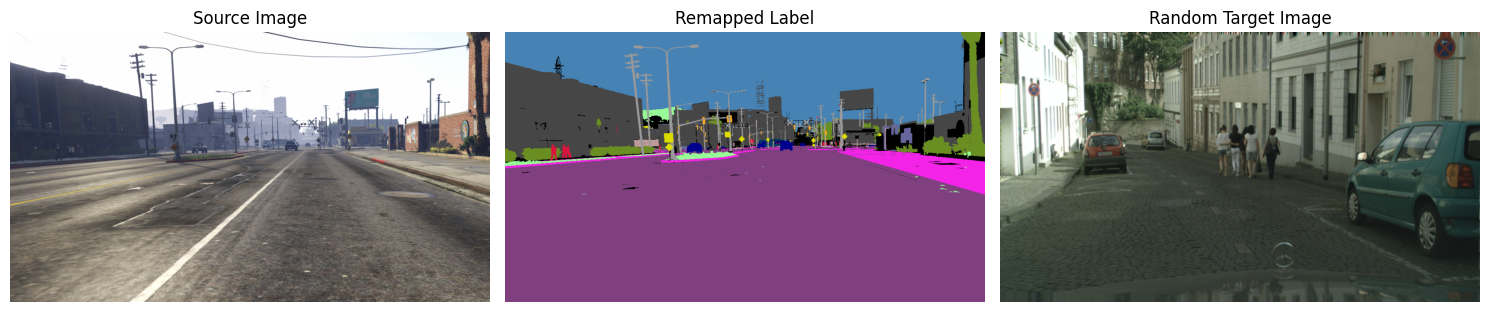

In [ ]:
def remap_gta5_labels(label_mask, mapping_dict, ignore_label=255):
    remapped = np.full_like(label_mask, fill_value=ignore_label)
    for gta_label, cityscapes_label in mapping_dict.items():
        remapped[label_mask == gta_label] = cityscapes_label
    return remapped
# ---- Palette e mapping ----
CITYSCAPES_PALETTE = {
    0:  (128,  64,128),   # road
    1:  (244,  35,232),   # sidewalk
    2:  ( 70,  70, 70),   # building
    3:  (102, 102,156),   # wall
    4:  (190, 153,153),   # fence
    5:  (153, 153,153),   # pole
    6:  (250, 170, 30),   # traffic light
    7:  (220, 220,  0),   # traffic sign
    8:  (107, 142, 35),   # vegetation
    9:  (152, 251,152),   # terrain
    10: ( 70, 130,180),   # sky
    11: (220,  20, 60),   # person
    12: (255,   0,  0),   # rider
    13: (  0,  0,142),    # car
    14: (  0,  0, 70),    # truck
    15: (  0, 60,100),    # bus
    16: (  0, 80,100),    # train
    17: (  0,  0,230),    # motorcycle
    18: (119, 11, 32),    # bicycle
    255: (  0,   0,   0),  # ignore
}
GTA5_to_Cityscapes = {
    7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10,
    24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18,
}
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)
    img = img_tensor.cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img.transpose(1,2,0)
def colorize_label(label_tensor, palette):
    label_np = label_tensor.cpu().numpy()
    color_label = np.zeros((label_np.shape[0], label_np.shape[1], 3), dtype=np.uint8)
    for lbl, color in palette.items():
        color_label[label_np == lbl] = color
    return color_label

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

image_aug_transforms = A.Compose([
    A.RandomScale(scale_limit=(0.0, 0.5), p=0.5),
    A.PadIfNeeded(min_height=720, min_width=1280,
                  border_mode=cv2.BORDER_CONSTANT,
                  value=0,
                  mask_value=255),
    A.RandomCrop(height=720, width=1280, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(5, 5), p=0.5),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])


# ---- ISTANZA DATASET E DATA LOADER ----
dataset = GTA5Dataset(
    gta5_root='/content/drive/MyDrive/GTA5',
    cityscapes_root='/content/drive/MyDrive/Cityscapes/Cityspaces',
    label_mapping=GTA5_to_Cityscapes,
    image_transform=image_aug_transforms
)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
# ---- VISUALIZZAZIONE ----
image, label, trg_image = next(iter(loader))
image = image[0]
label = label[0]
trg_image = trg_image[0]
img_vis = denormalize(image)
trg_img_vis = denormalize(trg_image)
label_vis = colorize_label(label, CITYSCAPES_PALETTE)
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(img_vis); axs[0].set_title('Source Image'); axs[0].axis('off')
axs[1].imshow(label_vis); axs[1].set_title('Remapped Label'); axs[1].axis('off')
axs[2].imshow(trg_img_vis); axs[2].set_title('Random Target Image'); axs[2].axis('off')
plt.tight_layout(); plt.show()

## Bisenet

In [ ]:
import torch
from torch import nn
import warnings
warnings.filterwarnings(action='ignore')

import torch
from torchvision import models
from itertools import chain


class resnet18(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet18(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


class resnet101(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet101(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


def build_contextpath(name):
    model = {
        'resnet18': resnet18(pretrained=True),
        'resnet101': resnet101(pretrained=True)
    }
    return model[name]


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))


class Spatial_path(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels=3, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, input):
        x = self.convblock1(input)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x


class AttentionRefinementModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input):
        # global average pooling
        x = self.avgpool(input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        x = self.sigmoid(self.bn(x))
        # x = self.sigmoid(x)
        # channels of input and x should be same
        x = torch.mul(input, x)
        return x


class FeatureFusionModule(torch.nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        # self.in_channels = input_1.channels + input_2.channels
        # resnet101 3328 = 256(from spatial path) + 1024(from context path) + 2048(from context path)
        # resnet18  1024 = 256(from spatial path) + 256(from context path) + 512(from context path)
        self.in_channels = in_channels

        self.convblock = ConvBlock(in_channels=self.in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input_1, input_2):
        x = torch.cat((input_1, input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.convblock(x)
        x = self.avgpool(feature)

        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        x = torch.add(x, feature)
        return x


class BiSeNet(torch.nn.Module):
    def __init__(self, num_classes, context_path):
        super().__init__()
        # build spatial path
        self.saptial_path = Spatial_path()

        # build context path
        self.context_path = build_contextpath(name=context_path)

        # build attention refinement module  for resnet 101
        if context_path == 'resnet101':
            self.attention_refinement_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_refinement_module2 = AttentionRefinementModule(2048, 2048)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=2048, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 3328)

        elif context_path == 'resnet18':
            # build attention refinement module  for resnet 18
            self.attention_refinement_module1 = AttentionRefinementModule(256, 256)
            self.attention_refinement_module2 = AttentionRefinementModule(512, 512)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 1024)
        else:
            print('Error: unspport context_path network \n')

        # build final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

        self.init_weight()

        self.mul_lr = []
        self.mul_lr.append(self.saptial_path)
        self.mul_lr.append(self.attention_refinement_module1)
        self.mul_lr.append(self.attention_refinement_module2)
        self.mul_lr.append(self.supervision1)
        self.mul_lr.append(self.supervision2)
        self.mul_lr.append(self.feature_fusion_module)
        self.mul_lr.append(self.conv)

    def init_weight(self):
        for name, m in self.named_modules():
            if 'context_path' not in name:
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    m.eps = 1e-5
                    m.momentum = 0.1
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # output of spatial path
        sx = self.saptial_path(input)

        # output of context path
        cx1, cx2, tail = self.context_path(input)
        cx1 = self.attention_refinement_module1(cx1)
        cx2 = self.attention_refinement_module2(cx2)
        cx2 = torch.mul(cx2, tail)
        # upsampling
        cx1 = torch.nn.functional.interpolate(cx1, size=sx.size()[-2:], mode='bilinear')
        cx2 = torch.nn.functional.interpolate(cx2, size=sx.size()[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)

        if self.training == True:
            cx1_sup = self.supervision1(cx1)
            cx2_sup = self.supervision2(cx2)
            cx1_sup = torch.nn.functional.interpolate(cx1_sup, size=input.size()[-2:], mode='bilinear')
            cx2_sup = torch.nn.functional.interpolate(cx2_sup, size=input.size()[-2:], mode='bilinear')

        # output of feature fusion module
        result = self.feature_fusion_module(sx, cx)

        # upsampling
        result = torch.nn.functional.interpolate(result, scale_factor=8, mode='bilinear')
        result = self.conv(result)

        if self.training == True:
            return result, cx1_sup, cx2_sup

        return result

    def optim_parameters(self, lr): # new
      return [
          {'params': self.context_path.parameters(), 'lr': lr},               # 1x
          {'params': chain(*(m.parameters() for m in self.mul_lr)), 'lr': lr * 10}  # 10x
      ]

In [ ]:
CITYSCAPES_CLASSES = [
    'Road', 'Sidewalk', 'Building', 'Wall', 'Fence', 'Pole', 'Traffic light',
    'Traffic sign', 'Vegetation', 'Terrain', 'Sky', 'Person', 'Rider', 'Car',
    'Truck', 'Bus', 'Train', 'Motorcycle', 'Bicycle'
]

## Training

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm

# prepare data

batch_size = 4
data_dir_train = '/content/drive/MyDrive/GTA5'
data_dir_val = '/content/drive/MyDrive/Cityscapes/Cityspaces'

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# the best one
image_aug_transforms = A.Compose([
    A.RandomScale(scale_limit=(0.0, 0.5), p=0.5),
    A.PadIfNeeded(min_height=720, min_width=1280,
                  border_mode=cv2.BORDER_CONSTANT,
                  value=0,
                  mask_value=255),
    A.RandomCrop(height=720, width=1280, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(5, 5), p=0.5),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_dataset = GTA5Dataset(
    gta5_root=data_dir_train,
    cityscapes_root=data_dir_val,
    label_mapping=GTA5_to_Cityscapes,
    image_transform=image_aug_transforms

)

val_dataset = CityscapesDataset(
    root_dir=data_dir_val,
    split="val",
    image_transform=image_transforms,
    label_transform=None
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=4)

Number of GTA5 images found: 2500
Number of Cityscapes images found: 2072


In [ ]:
def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1,
                      max_iter=300, power=0.9):
    """Polynomial decay of learning rate
            :param init_lr is base learning rate
            :param iter is a current iteration
            :param lr_decay_iter how frequently decay occurs, default is 1
            :param max_iter is number of maximum iterations
            :param power is a polymomial power

    """

    lr = init_lr*(1 - iter/max_iter)**power
    optimizer.param_groups[0]['lr'] = lr
    optimizer.param_groups[1]['lr'] = lr * 10 # new
    return lr


def fast_hist(a, b, n):
    '''
    a and b are label and prediction respectively
    n is the number of classes
    '''
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)


def per_class_iou(hist):
    epsilon = 1e-5
    return (np.diag(hist)) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

In [ ]:
log_path = '/content/drive/MyDrive/semantic segmentation/bisenet+fda/bisenet_train_log.csv'
chkpt = "/content/drive/MyDrive/semantic segmentation/bisenet+fda/checkpoint.pth"
lossmiou = '/content/drive/MyDrive/semantic segmentation/bisenet+fda/bisenet_loss_miou_plot.png'

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.cuda.amp import autocast

# ======= PSEUDO-LABELS BATCH PROCESSING =======
@torch.no_grad()
def compute_pseudo_labels_batch(model, target_images, device):
    """
    Computes pseudo-labels for the entire batch in a single forward pass.

    Args:
        model (torch.nn.Module): The segmentation model.
        target_images (torch.Tensor): A batch of input images (target domain).
        device (torch.device): The device (CPU or CUDA).

    Returns:
        target_pseudo (torch.Tensor): Predicted pseudo-labels (H x W) per image.
        target_confidence (torch.Tensor): Confidence scores per pixel.
        batch_avg_confidence (float): Average confidence over the batch.
    """
    model.eval()

    with autocast():
        # Single forward pass on the entire batch
        target_outputs = model(target_images)
        target_probs = F.softmax(target_outputs, dim=1)
        target_confidence, target_pseudo = target_probs.max(dim=1)

    # Compute average confidence over the whole batch (for adaptive thresholding)
    batch_avg_confidence = target_confidence.mean().item()

    return target_pseudo, target_confidence, batch_avg_confidence


In [ ]:
import torch
import numpy as np

def colorize_label(label_tensor, palette):
    """
    Converts a segmentation label map (with class indices) into a color image.

    Args:
        label_tensor (torch.Tensor or np.ndarray): 2D tensor or array with class indices.
        palette (dict): Mapping from class index to RGB color (tuple of 3 ints).

    Returns:
        np.ndarray: 3D array (H x W x 3) representing the colorized label image.
    """
    if isinstance(label_tensor, torch.Tensor):
        label_np = label_tensor.cpu().numpy()
    else:
        label_np = label_tensor

    color_label = np.zeros((label_np.shape[0], label_np.shape[1], 3), dtype=np.uint8)
    for lbl, color in palette.items():
        color_label[label_np == lbl] = color

    return color_label

# Cityscapes color palette (class index -> RGB color)
CITYSCAPES_PALETTE = {
     0: (128,  64,128),   1: (244,  35,232),  2: ( 70,  70, 70),
     3: (102, 102,156),   4: (190, 153,153),  5: (153, 153,153),
     6: (250, 170, 30),   7: (220, 220,  0),  8: (107, 142, 35),
     9: (152, 251,152),  10: ( 70, 130,180), 11: (220,  20, 60),
    12: (255,   0,  0),  13: (  0,   0,142), 14: (  0,   0, 70),
    15: (  0,  60,100),  16: (  0,  80,100), 17: (  0,   0,230),
    18: (119,  11, 32), 255: (  0,   0,  0)  # 255 is often used as "ignore index"
}

def denormalize_img(img):
    """
    Reverts ImageNet normalization on an image and converts it to uint8 format.

    Args:
        img (np.ndarray): Image array of shape [H, W, 3], normalized using ImageNet mean/std.

    Returns:
        np.ndarray: Denormalized image with values in [0, 255] as uint8, suitable for imshow.
    """
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_dn = img * std + mean
    img_dn = np.clip(img_dn, 0, 1)
    return (img_dn * 255).astype(np.uint8)


In [ ]:
# ======= FOCAL LOSS =======
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, ignore_index=255, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', ignore_index=self.ignore_index)
        pt = torch.exp(-ce_loss)
        focal_weight = self.alpha * (1 - pt) ** self.gamma
        focal_loss = focal_weight * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
# ======= ADAPTIVE THRESHOLD =======
def adaptive_threshold(model_confidence_history, percentile=90, min_threshold=0.7, max_threshold=0.9):

    recent_confidences = list(model_confidence_history)[-100:]
    threshold = np.percentile(recent_confidences, percentile)
    threshold = np.clip(threshold, min_threshold, max_threshold)

    return float(threshold)

In [ ]:
# ======= CHECKPOINT FUNCTIONS =======

def save_checkpoint(model, optimizer, scaler, epoch, train_losses, ce_losses, unsup_losses,
                    val_mious, confidence_history, best_miou, filename='last_checkpoint.pth'):
    """
    Save full checkpoint of the training state
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'train_losses': train_losses,
        'ce_losses': ce_losses,
        'unsup_losses': unsup_losses,
        'val_mious': val_mious,
        'confidence_history': list(confidence_history),
        'best_miou': best_miou,
        'learning_rate': learning_rate,
        'threshold': threshold
    }
    torch.save(checkpoint, filename)
    print(f"✓ Checkpoint saved: {filename}")

def load_checkpoint(model, optimizer, scaler, filename='last_checkpoint.pth'):
    """
    Load a checkpoint and restore the training state
    """
    if not os.path.exists(filename):
        print(f"No checkpoint found: {filename}")
        return None

    print(f"Loading checkpoint: {filename}")
    checkpoint = torch.load(filename, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])

    # Restore tracking lists
    train_losses = checkpoint['train_losses']
    ce_losses = checkpoint['ce_losses']
    unsup_losses = checkpoint['unsup_losses']
    val_mious = checkpoint['val_mious']
    confidence_history = deque(checkpoint['confidence_history'], maxlen=200)
    best_miou = checkpoint['best_miou']
    start_epoch = checkpoint['epoch'] + 1

    print(f"✓ Checkpoint loaded!")
    print(f"  - Resuming from epoch: {start_epoch}")
    print(f"  - Previous best mIoU: {best_miou:.4f}")
    print(f"  - Training epochs completed: {len(train_losses)}")

    return {
        'start_epoch': start_epoch,
        'train_losses': train_losses,
        'ce_losses': ce_losses,
        'unsup_losses': unsup_losses,
        'val_mious': val_mious,
        'confidence_history': confidence_history,
        'best_miou': best_miou
    }

def save_best_model(model, filename='best_model.pth'):
    """
    Save only the model (for inference)
    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'num_classes': 19,
        'context_path': 'resnet18'
    }, filename)
    print(f"✓ Best model saved: {filename}")

No checkpoint found: drive/MyDrive/last_checkpoint_dacs.pth
Setup completed: Focal Loss (α=1.0, γ=2.0)
Training starts from epoch: 1


Epoch 1/50 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

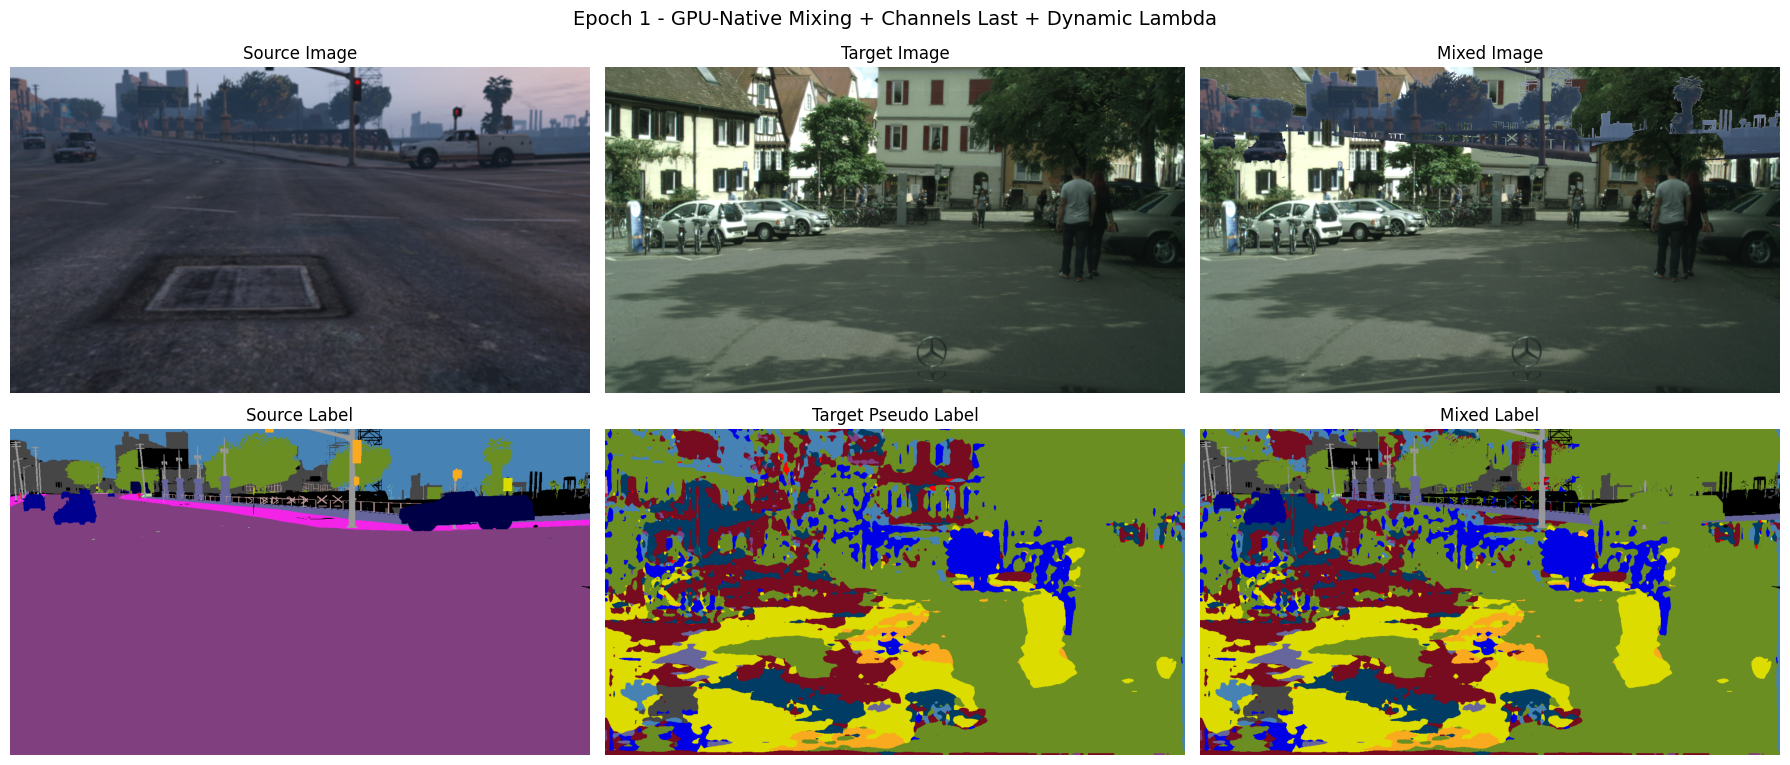

Epoch 1: Average Dynamic Lambda = 0.4131
[EPOCH 1] Train Loss: 14.5713 | Focal Sup: 1.3843 | Unsup: 0.4371 | Adaptive Thr: 0.7500


[EPOCH 1] Val mIoU: 0.1208
✓ Checkpoint saved: drive/MyDrive/last_checkpoint_dacs.pth
✓ Best model saved: drive/MyDrive/best_model_dacs.pth
🎉 New best mIoU: 0.1208


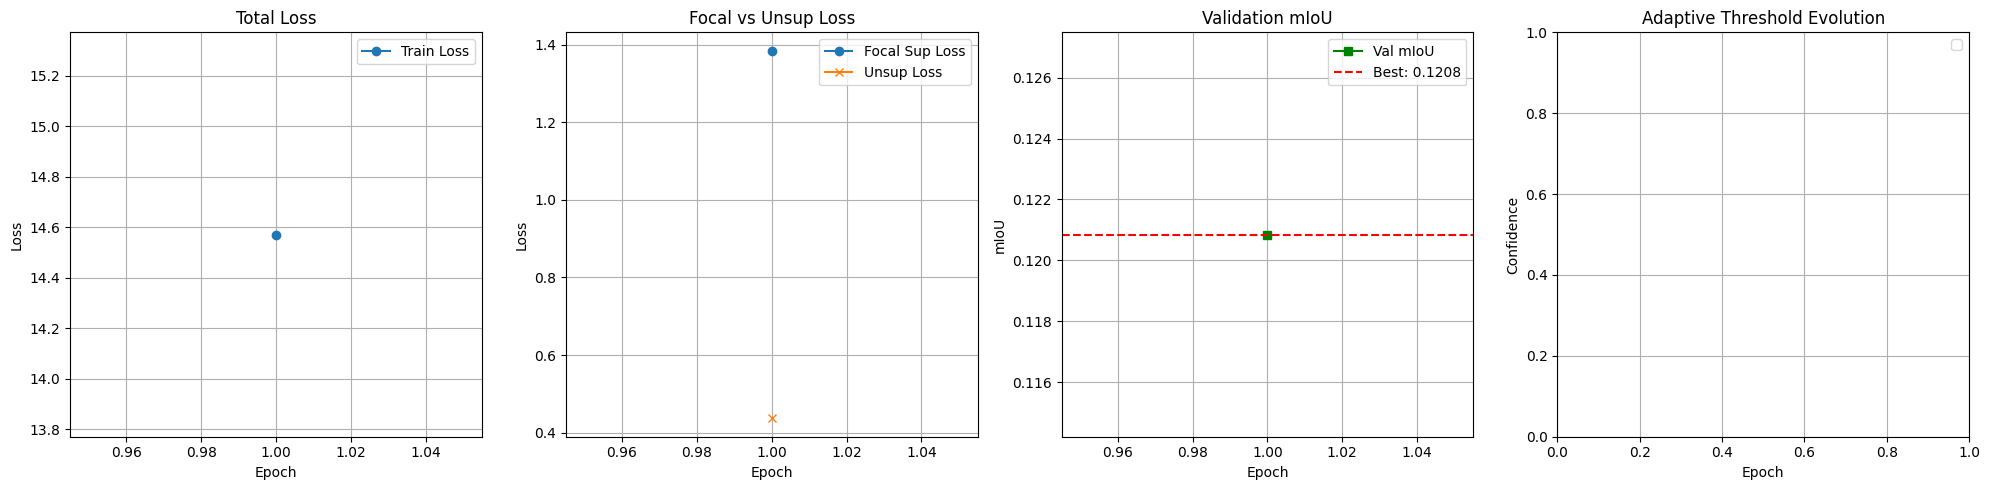

Epoch 2/50 [Train]:   0%|          | 0/625 [00:00<?, ?it/s]

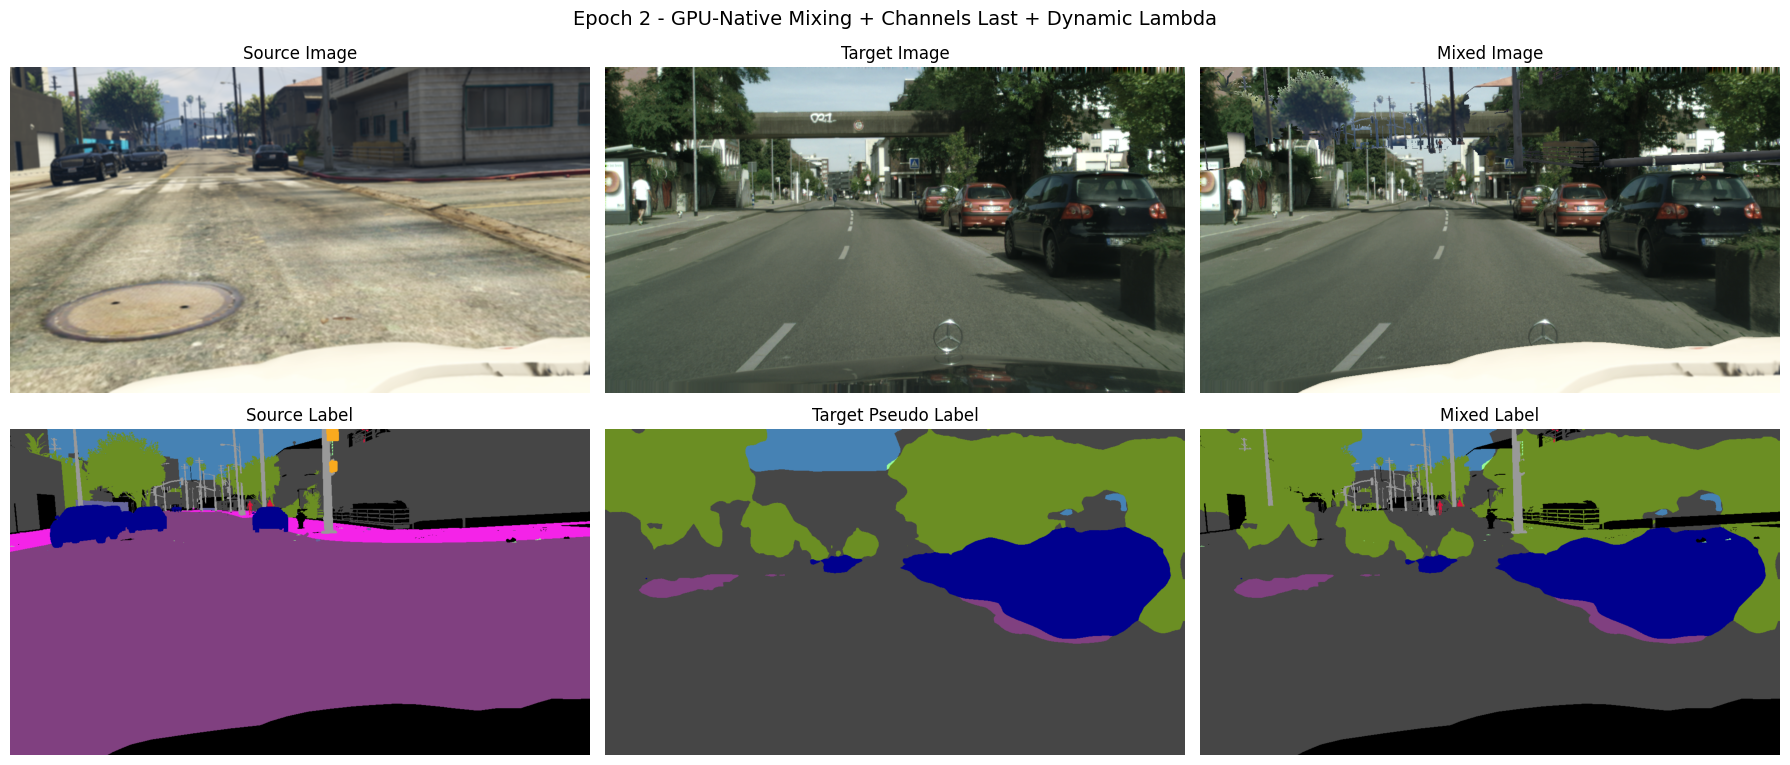

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import deque
import os

# --- Setup ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()
epochs = 50
max_iter = len(train_dataloader) * epochs
iteration = 0

train_losses = []
ce_losses = []
unsup_losses = []
val_mious = []

threshold = 0.75
best_miou = 0.0
start_epoch = 0

accumulation_steps = 8  # gradient accumulation
confidence_history = deque(maxlen=200)
learning_rate = 1e-2

model = BiSeNet(num_classes=19, context_path='resnet18')
optimizer = optim.SGD(model.optim_parameters(learning_rate), momentum=0.9, weight_decay=5e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ======= OPTIMIZATION 1: GPU-NATIVE MIXING STRATEGY =======
def gpu_native_mixing_strategy(source_images, source_labels, target_images, target_pseudo_labels, device):
    """
    Mixing strategy operating COMPLETELY on GPU, without CPU transfers
    """
    batch_size = source_images.shape[0]
    mixed_images = torch.zeros_like(source_images, device=device)
    mixed_labels = torch.zeros_like(source_labels, device=device)
    for i in range(batch_size):
        src_lbl = source_labels[i]   # On GPU
        tgt_pseudo = target_pseudo_labels[i]  # On GPU

        # Find unique classes directly on GPU
        unique_classes = torch.unique(src_lbl)

        # Handle edge cases
        if len(unique_classes) <= 1:
            mixed_images[i] = source_images[i]
            mixed_labels[i] = source_labels[i]
            continue

        # Select half of the classes (GPU op)
        num_classes_to_select = max(1, len(unique_classes) // 2)
        perm_indices = torch.randperm(len(unique_classes), device=device)[:num_classes_to_select]
        selected_classes = unique_classes[perm_indices]

        # Create binary mask on GPU
        mask = torch.zeros_like(src_lbl, dtype=torch.bool, device=device)
        mask = torch.isin(src_lbl, selected_classes)

        # Apply mixing on GPU
        # For images: expand mask to all channels
        mask_expanded = mask.unsqueeze(0).expand_as(source_images[i])  # [C, H, W]
        mixed_images[i] = torch.where(mask_expanded, source_images[i], target_images[i])

        # For labels: use mask directly
        mixed_labels[i] = torch.where(mask, src_lbl, tgt_pseudo)

    return mixed_images, mixed_labels

# Loss functions - FOCAL LOSS
focal_criterion = FocalLoss(alpha=1.0, gamma=2.0, ignore_index=255)
criterion = focal_criterion

# ======= LOAD CHECKPOINT IF EXISTS =======
checkpoint_data = load_checkpoint(model, optimizer, scaler, 'drive/MyDrive/last_checkpoint_dacs.pth')
if checkpoint_data:
    start_epoch = checkpoint_data['start_epoch']
    train_losses = checkpoint_data['train_losses']
    ce_losses = checkpoint_data['ce_losses']
    unsup_losses = checkpoint_data['unsup_losses']
    val_mious = checkpoint_data['val_mious']
    confidence_history = checkpoint_data['confidence_history']
    best_miou = checkpoint_data['best_miou']

print(f"Setup completed: Focal Loss (α={criterion.alpha}, γ={criterion.gamma})")
print(f"Training starts from epoch: {start_epoch + 1}")

# ======= TRAINING LOOP WITH CHECKPOINT SYSTEM AND DYNAMIC LAMBDA =======
for epoch in range(start_epoch, epochs):
    model.train()
    running_total_loss = 0.0
    running_sup_loss = 0.0
    running_unsup_loss = 0.0
    batch_count = 0

    # Batch confidence for adaptive threshold calculation
    epoch_confidences = []
    # Track dynamic lambda for monitoring
    epoch_lambda_values = []

    # ADAPTIVE THRESHOLD
    if len(confidence_history) > 10:
        current_threshold = adaptive_threshold(confidence_history, percentile=70)
    else:
        current_threshold = threshold

    train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

    for batch_idx, (source_images, source_labels, target_images) in enumerate(train_loader_tqdm):

        # GPU transfer with optimized memory format
        source_images = source_images.to(device, non_blocking=True, memory_format=torch.channels_last)
        source_labels = source_labels.to(device, dtype=torch.long, non_blocking=True)
        target_images = target_images.to(device, non_blocking=True, memory_format=torch.channels_last)

        batch_size = source_images.shape[0]

        # ======= PSEUDO-LABELS BATCH PROCESSING =======
        target_pseudo_labels, target_confidence, batch_avg_confidence = compute_pseudo_labels_batch(
            model, target_images, device
        )
        epoch_confidences.append(batch_avg_confidence)

        # ======= GPU-NATIVE MIXING STRATEGY =======
        mixed_images, mixed_labels = gpu_native_mixing_strategy(
            source_images, source_labels, target_images, target_pseudo_labels, device
        )

        # Visualization
        if (batch_idx == 0):
            # Convert to CPU for visualization only
            first_img = source_images[0]

            def prep_img_for_viz(img_tensor):
                img_cpu = img_tensor.cpu().permute(1, 2, 0).numpy()
                return denormalize_img(img_cpu)

            i = 0  # First sample
            src_img_viz = prep_img_for_viz(source_images[i])
            tgt_img_viz = prep_img_for_viz(target_images[i])
            mixed_img_viz = prep_img_for_viz(mixed_images[i])

            src_lbl_viz = source_labels[i].cpu().numpy()
            tgt_pseudo_viz = target_pseudo_labels[i].cpu().numpy()
            mixed_lbl_viz = mixed_labels[i].cpu().numpy()

            fig, axs = plt.subplots(2, 3, figsize=(18, 8))
            axs[0,0].imshow(src_img_viz)
            axs[0,0].set_title("Source Image")
            axs[0,1].imshow(tgt_img_viz)
            axs[0,1].set_title("Target Image")
            axs[0,2].imshow(mixed_img_viz)
            axs[0,2].set_title("Mixed Image")
            axs[1,0].imshow(colorize_label(src_lbl_viz, CITYSCAPES_PALETTE))
            axs[1,0].set_title("Source Label")
            axs[1,1].imshow(colorize_label(tgt_pseudo_viz, CITYSCAPES_PALETTE))
            axs[1,1].set_title(f"Target Pseudo Label")
            axs[1,2].imshow(colorize_label(mixed_lbl_viz, CITYSCAPES_PALETTE))
            axs[1,2].set_title("Mixed Label")
            for ax in axs.ravel():
                ax.axis('off')
            plt.suptitle(f'Epoch {epoch+1} - Visualization', fontsize=14)
            plt.tight_layout()
            plt.show()

        with autocast():
            model.train()
            # ----- SUPERVISED LOSS with FOCAL LOSS -----
            outputs, aux1, aux2 = model(source_images)
            loss_main = criterion(outputs, source_labels)
            loss_aux1 = criterion(aux1, source_labels)
            loss_aux2 = criterion(aux2, source_labels)
            loss_sup = loss_main + 0.4 * loss_aux1 + 0.4 * loss_aux2

            # ----- UNSUPERVISED LOSS with ADAPTIVE THRESHOLD -----
            outputs2, aux12, aux22 = model(mixed_images)
            # Unsupervised loss with adaptive threshold
            loss_unsup_per_pixel = F.cross_entropy(outputs2, mixed_labels, reduction='none', ignore_index=255)
            probs = F.softmax(outputs2, dim=1)
            confidence, _ = probs.max(dim=1)
            # Use adaptive threshold to create confidence mask
            confidence_mask = (confidence > current_threshold).float()

            # ======= DYNAMIC LAMBDA CALCULATION =======
            # Lambda = mean proportion of confident pixels in the batch
            # For each image in the batch, compute the percentage of confident pixels
            batch_confident_proportions = []
            for b in range(batch_size):
                # Valid pixels (not ignore_index=255)
                valid_mask = (mixed_labels[b] != 255)
                n_valid_pixels = valid_mask.sum().float()
                if n_valid_pixels > 0:
                    # Confident pixels among valid ones
                    confident_pixels = (confidence_mask[b] * valid_mask.float()).sum()
                    proportion = confident_pixels / n_valid_pixels
                else:
                    proportion = torch.tensor(0.0, device=device)
                batch_confident_proportions.append(proportion)

            # Mean batch proportions = dynamic lambda
            lambda_u = torch.stack(batch_confident_proportions).mean()

            # Tracking for monitoring
            epoch_lambda_values.append(lambda_u.item())

            # Weighted unsupervised loss
            loss_unsup_masked = loss_unsup_per_pixel * confidence_mask
            loss_unsup = loss_unsup_masked.sum() / (confidence_mask.sum() + 1e-10)

            # Auxiliary losses for unsupervised
            loss_aux1_unsup = F.cross_entropy(aux12, mixed_labels, reduction='none', ignore_index=255)
            loss_aux2_unsup = F.cross_entropy(aux22, mixed_labels, reduction='none', ignore_index=255)
            loss_aux1_unsup_masked = (loss_aux1_unsup * confidence_mask).sum() / (confidence_mask.sum() + 1e-10)
            loss_aux2_unsup_masked = (loss_aux2_unsup * confidence_mask).sum() / (confidence_mask.sum() + 1e-10)
            loss_unsup_total = loss_unsup + 0.4 * loss_aux1_unsup_masked + 0.4 * loss_aux2_unsup_masked

            # Apply dynamic lambda to unsupervised loss
            total_loss = loss_sup + lambda_u * loss_unsup_total
            actual_total_loss = total_loss.item() * accumulation_steps

            # GRADIENT ACCUMULATION
            total_loss = total_loss / accumulation_steps

        # Backward pass
        scaler.scale(total_loss).backward()

        # GRADIENT ACCUMULATION: update parameters every accumulation_steps
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_dataloader):
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        iteration += 1

        # Loss tracking
        actual_sup_loss = loss_sup.item()
        actual_unsup_loss = (lambda_u * loss_unsup_total).item()
        running_total_loss += actual_total_loss
        running_sup_loss += actual_sup_loss
        running_unsup_loss += actual_unsup_loss
        batch_count += 1

        # Progress bar with optimization info + dynamic lambda
        train_loader_tqdm.set_postfix({
            'loss': f'{actual_total_loss:.4f}',
            'sup': f'{actual_sup_loss:.4f}',
            'unsup': f'{actual_unsup_loss:.4f}',
            'λ_dyn': f'{lambda_u.item():.3f}',
            'thr_ada': f'{current_threshold:.3f}',
            'conf': f'{confidence_mask.mean().item():.3f}',
            'best_mIoU': f'{best_miou:.3f}'
        })

        # Periodic memory cleanup
        if batch_idx % 50 == 0:
            torch.cuda.empty_cache()

    # === END OF EPOCH: UPDATE CONFIDENCE HISTORY AND LAMBDA TRACKING ===
    if epoch_confidences:
        epoch_avg_confidence = np.mean(epoch_confidences)
        confidence_history.append(epoch_avg_confidence)

    # Mean value of dynamic lambdas for the epoch
    if epoch_lambda_values:
        epoch_avg_lambda = np.mean(epoch_lambda_values)
        print(f"Epoch {epoch+1}: Average Dynamic Lambda = {epoch_avg_lambda:.4f}")

    # --- End of epoch: averages ---
    avg_total_loss = running_total_loss / batch_count
    avg_sup_loss = running_sup_loss / batch_count
    avg_unsup_loss = running_unsup_loss / batch_count
    train_losses.append(avg_total_loss)
    ce_losses.append(avg_sup_loss)
    unsup_losses.append(avg_unsup_loss)

    # --- VALIDATION ---
    print(f"[EPOCH {epoch+1}] Train Loss: {avg_total_loss:.4f} | "
          f"Focal Sup: {avg_sup_loss:.4f} | "
          f"Unsup: {avg_unsup_loss:.4f} | "
          f"Adaptive Thr: {current_threshold:.4f}")

    model.eval()
    hist = np.zeros((19, 19))
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
            # Apply channels_last for validation as well
            images = images.to(device, memory_format=torch.channels_last)
            masks = masks.to(device, dtype=torch.long)
            with autocast():
                outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            targets = masks.cpu().numpy()
            targets[targets == 255] = -1
            for lt, lp in zip(targets, preds):
                hist += fast_hist(lt.flatten(), lp.flatten(), 19)

    ious = per_class_iou(hist)
    mean_iou = np.nanmean(ious)
    val_mious.append(mean_iou)

    print(f"[EPOCH {epoch+1}] Val mIoU: {mean_iou:.4f}")

    # ======= CHECKPOINT SYSTEM =======
    # Save checkpoint at end of each epoch
    save_checkpoint(
        model, optimizer, scaler, epoch,
        train_losses, ce_losses, unsup_losses, val_mious,
        confidence_history, best_miou,
        filename='drive/MyDrive/last_checkpoint_dacs.pth'
    )

    # Save best model if needed
    if mean_iou > best_miou:
        best_miou = mean_iou
        save_best_model(model, 'drive/MyDrive/best_model_dacs.pth')
        print(f"🎉 New best mIoU: {best_miou:.4f}")

    # --- LIVE PLOT ---
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'o-', label='Train Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Total Loss'); plt.legend(); plt.grid()
    plt.subplot(1, 4, 2)
    plt.plot(range(1, len(ce_losses) + 1), ce_losses, 'o-', label='Focal Sup Loss')
    plt.plot(range(1, len(unsup_losses) + 1), unsup_losses, 'x-', label='Unsup Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Focal vs Unsup Loss'); plt.legend(); plt.grid()
    plt.subplot(1, 4, 3)
    plt.plot(range(1, len(val_mious) + 1), val_mious, 's-', color='green', label='Val mIoU')
    plt.axhline(y=best_miou, color='red', linestyle='--', label=f'Best: {best_miou:.4f}')
    plt.xlabel('Epoch'); plt.ylabel('mIoU'); plt.title('Validation mIoU'); plt.legend(); plt.grid()
    plt.subplot(1, 4, 4)
    if len(confidence_history) > 1:
        conf_epochs = range(max(1, epoch+2-len(confidence_history)), epoch+2)
        plt.plot(conf_epochs, list(confidence_history), 'v-', color='purple', label='Adaptive Threshold')
        plt.axhline(y=current_threshold, color='red', linestyle='--', label=f'Current Thr: {current_threshold:.3f}')
    plt.xlabel('Epoch'); plt.ylabel('Confidence'); plt.title('Adaptive Threshold Evolution'); plt.legend(); plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

print("Training completed with Focal Loss, Adaptive Threshold, and Checkpoint System!")
print(f"Best mIoU achieved: {best_miou:.4f}")
print(f"Final Confidence History: {len(confidence_history)} values recorded")
print(f"Models saved:")
print(f"  - Last checkpoint: last_checkpoint.pth")
print(f"  - Best model: best_model.pth")

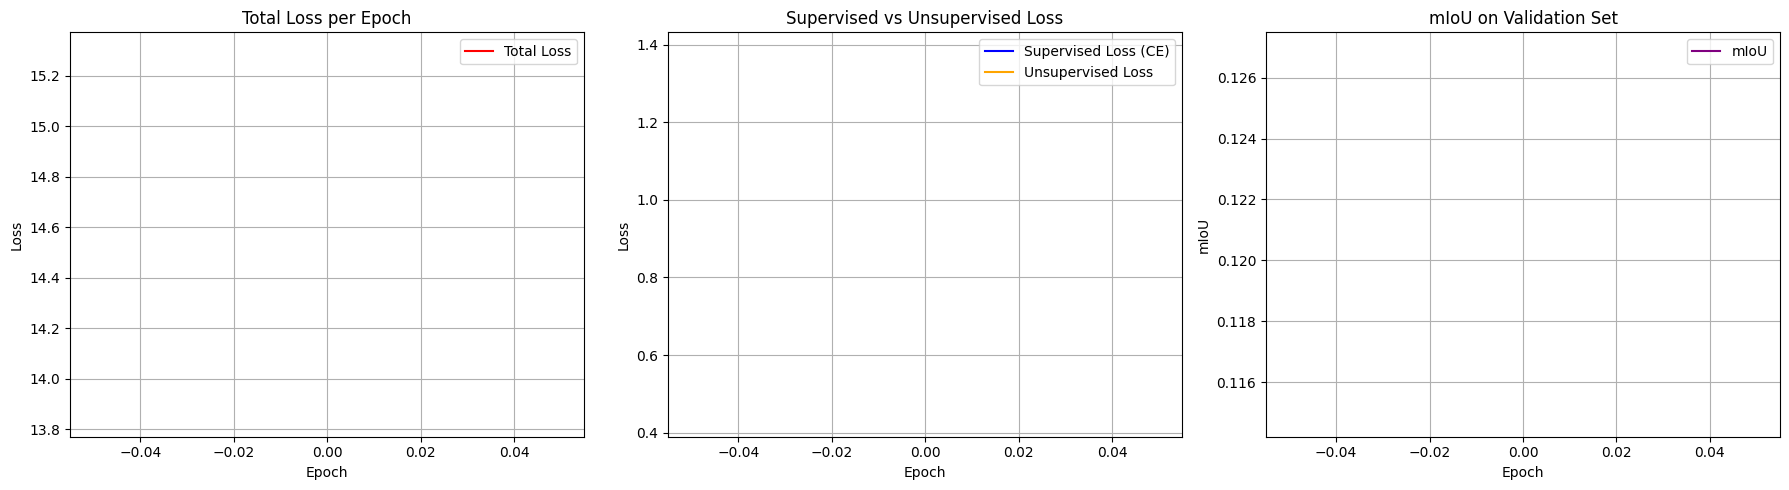

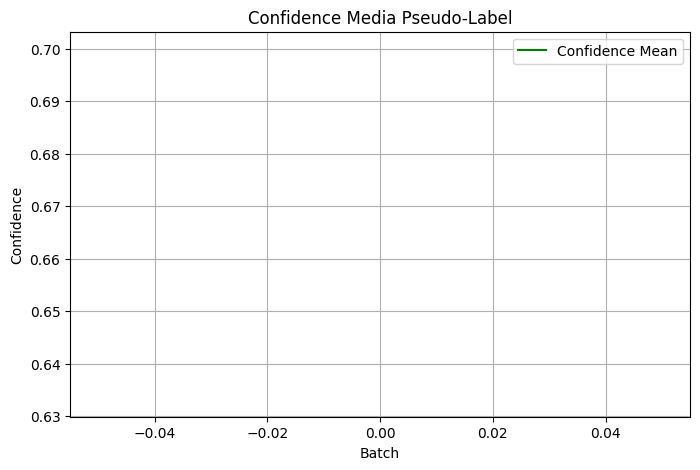

In [ ]:
import torch
import matplotlib.pyplot as plt

# Carica il checkpoint
checkpoint = torch.load('drive/MyDrive/last_checkpoint_dacs.pth', map_location='cpu', weights_only=False)

# Estrai le liste
train_losses = checkpoint['train_losses']
ce_losses = checkpoint['ce_losses']
unsup_losses = checkpoint['unsup_losses']
confidence_history = checkpoint.get('confidence_history', [])
val_mious = checkpoint['val_mious']

# Figura con tre subplot affiancati
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Total Loss
axs[0].plot(train_losses, label='Total Loss', color='red')
axs[0].set_title("Total Loss per Epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].grid(True)
axs[0].legend()

# CE vs Unsupervised Loss
axs[1].plot(ce_losses, label='Supervised Loss (CE)', color='blue')
axs[1].plot(unsup_losses, label='Unsupervised Loss', color='orange')
axs[1].set_title("Supervised vs Unsupervised Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].grid(True)
axs[1].legend()

# mIoU
if val_mious:
    axs[2].plot(val_mious, label='mIoU', color='purple')
    axs[2].set_title("mIoU on Validation Set")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("mIoU")
    axs[2].grid(True)
    axs[2].legend()
else:
    axs[2].set_visible(False)
    print("⚠️ Nessuna 'miou_history' trovata nel checkpoint.")

plt.tight_layout()
plt.show()

# Confidence History separato
if confidence_history:
    plt.figure(figsize=(8, 5))
    plt.plot(confidence_history, label='Confidence Mean', color='green')
    plt.xlabel("Batch")
    plt.ylabel("Confidence")
    plt.title("Confidence Media Pseudo-Label")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ Nessuna 'confidence_history' trovata nel checkpoint.")
